**Цель проекта** - исследовать, почему лишь 5-10% пользователей Stepik, записавшихся на онлайн-курс, проходят его до конца, и что нужно сделать, чтобы увеличить этот показатель.
Материалом для нашего исследования будет служить курс "Введение в анализ данных на R" (https://stepik.org/course/129/syllabus)
Ссылка на оригинальное условие: https://stepik.org/lesson/222124/step/3?unit=195045

**Описание данных**

1) events_train.csv - данные о действиях, которые совершают студенты со стэпами (ссылка на данные: https://stepik.org/media/attachments/course/4852/event_data_train.zip)

> 

*   step_id - id стэпа
*   user_id - анонимизированный id пользователя
*   timestamp - время наступления события в формате unix date
*   action - событие

Возможные значения колонки action:

    discovered - пользователь перешел на стэп
    viewed - просмотр шага,
    started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
    passed - удачное решение практического шага

2) submissions_train.csv - данные о времени и статусах сабмитов (отправок решений) к практическим заданиям (ссылка на данные: https://stepik.org/media/attachments/course/4852/submissions_data_train.zip)


> 

*   step_id - id стэпа
*   timestamp - время отправки решения в формате unix date
*   submission_status - статус решения
*   user_id - анонимизированный id юзера



---


Импорт нужных библиотек

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set(rc={'figure.figsize': (9, 6)})

# **Часть 1. Обработка данных**

Открытие файлов с данными

In [4]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression='zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression='zip')

Преобразуем дату, чтобы с ней было удобнее работать

In [5]:
# unit='s' означает, что timestap представлен в секундах
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

График количества новых пользователей, которые занимались на курсе в каждый из дней

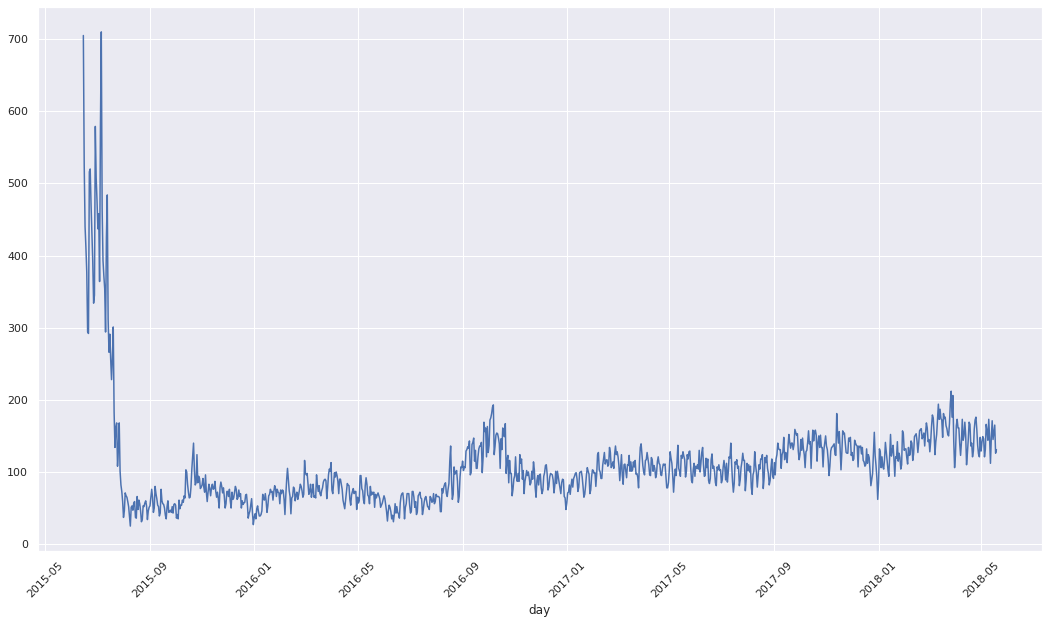

In [6]:
fig = events_data.groupby('day').user_id.nunique().plot(figsize=(18, 10)).tick_params(axis='x', rotation=45)

Посчитаем, по сколько баллов набрали пользователи, и отобразим зависимость на графике

In [7]:
users_events_data = events_data.pivot_table(
    index='user_id', 
    columns='action', 
    values='step_id', 
    aggfunc='count', 
    fill_value=0
).reset_index()

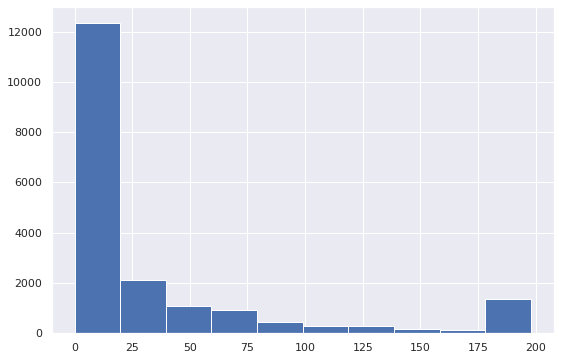

In [8]:
users_events_data.passed.hist()

Посчитаем количество корректных сабмитов для каждого пользователя

In [9]:
users_scores = submissions_data.pivot_table(
    index='user_id', 
    columns='submission_status', 
    values='step_id', 
    aggfunc='count', 
    fill_value=0
).reset_index()

In [10]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Теперь мы хотим научиться предсказывать, бросил ли пользователь курс или он ещё в процессе прохождения. Единственно правильного решения здесь нет. Придумаем эвристику, изучив наши данные

Для этого посмотрим, какие средние промежутки между сабмитами у каждого пользователя

In [11]:
# для каждого пользователя оставляем только одно действие в день (то есть timestamp этих действий)
# и запишем эти timestamp в список, а затем применим функцию np.diff, которая
# считает разницу между соседними элементами списка

gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [12]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

Теперь gap_data содержит наименьшую разницу между двумя заходами на курс для каждого пользователя (в секундах)
Чтобы получить эту разницу в днях, нужно разделить gap_data на 24 * 60 * 60

In [13]:
gap_data.quantile(0.90) / (24 * 60 * 60)

18.325995370370403

Значение квантиля означает, что только 10% пользователей возвращается на курс после перерыва в 18 дней

Для точности возьмём оценку перерыва в 30 дней

Разделим пользователей на бросивших курс и не бросивших

In [14]:
timestamp_border = 30 * 24 * 60 * 60
current_timestamp = 1526772811

In [15]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={'timestamp': 'last_timestamp'})

In [16]:
users_data['is_gone_user'] = (current_timestamp - users_data['last_timestamp']) > timestamp_border

In [17]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

In [18]:
users_data = users_data.merge(users_events_data, how='outer')

In [19]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [20]:
users_data = users_data.merge(users_days, how='outer')

In [21]:
# passed_course == True <==> пользователь успешно закончил курс

users_data['passed_course'] = users_data['passed'] > 170

In [22]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [23]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [24]:
100 * 1425 / (1425 + 17809)

7.408755329104711

Отсюда мы видим, что курс прошло только ~7% пользователей

# **Часть 2. Подготовка данных для обучения**

Нам нужно как можно раньше предсказать, что пользователь уйдёт с курса.
Попробуем проанализировать данные за первые N дней и на основании этого предсказать, уйдёт ли пользователь с курса

Положим N = 3

In [25]:
# когда пользователь сделал первое активное действие на курсе
user_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'min'}) \
                .rename({'timestamp': 'min_timestamp'}, axis=1)

In [26]:
users_data = users_data.merge(user_min_time, how='outer')

In [27]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [28]:
learning_time_threshold = 3 * 24 * 60 * 60

In [29]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + \
                               (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [30]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [31]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [32]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [33]:
events_data_train.shape

(1014985, 8)

In [34]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [35]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]

In [36]:
submissions_data_train.groupby('user_id').day.nunique().max()

4

Создадим датафрейм для обучения модели

In [37]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns={'day': 'days'})

In [38]:
# сколько у каждого пользователя уникальных степов, которые он пытался решить

steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
              .rename(columns={'step_id': 'steps_tried'})

In [39]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [40]:
X = X.merge(submissions_data_train.pivot_table(
    index='user_id',
    columns='submission_status',
    values='step_id',
    aggfunc='count',
    fill_value=0
).reset_index())

In [41]:
# доля правильных ответов на задания

X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [42]:
# Сколько суммарно у нас было просмотренных стэпов для каждого пользователя

X = X.merge(events_data_train.pivot_table(
    index='user_id',
    columns='action',
    values='step_id',
    aggfunc='count',
    fill_value=0
).reset_index()[['user_id', 'viewed']], how='outer')

In [43]:
X = X.fillna(0)

In [44]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [45]:
# ~ обозначает логическое отрицание (not)

X = X[X.is_gone_user | X.passed_course]

In [46]:
y = X.passed_course

In [47]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [48]:
X = X.set_index(X.user_id)

In [49]:
X = X.drop(['user_id'], axis=1)

In [51]:
y = y.map(int)

# **Часть 3. Обучение модели**

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [78]:
clf = RandomForestClassifier(random_state=0, n_jobs=-1)
parameters = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(3, 11, 2),
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(1, 10)
}

In [79]:
randomized_clf = RandomizedSearchCV(clf, parameters, cv=5, n_jobs=-1)

In [80]:
randomized_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(3, 11, 2),
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 11, 2),
                                        'n_estimators': range(10, 101, 10)})

In [81]:
randomized_clf.best_params_

{'n_estimators': 50,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_depth': 5}

In [82]:
best_clf = randomized_clf.best_estimator_

Осталось проверить качество модели

In [84]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [83]:
best_clf.score(X_test, y_test)

0.9321091644204852

In [86]:
y_pred = best_clf.predict(X_test)

In [87]:
precision_score(y_test, y_pred)

0.6507936507936508

In [89]:
recall_score(y_test, y_pred)

0.0971563981042654

In [91]:
f1_score(y_test, y_pred)

0.16907216494845362

Итак, мы получили очень хорошую модель по показателю точности предсказаний (93%) и precision, хотя recall и F1-score хромают, хотя они здесь не особо важны

Так что наш эксперимент можно считать удачным!